In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)

In [114]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

In [115]:
orbitals = {
    'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'gthszvmolopt': {6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]]}
}

In [116]:
device = 'cpu'

In [117]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'sto-3g'
START = 0
STOP = 1
frames = read(f'{root}/deepH_graphene/deepH_graphene.xyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True]

kmesh = [1,1,1]
kfock = [np.load(f"{root}/deepH_graphene/realfock_{i}.npy", allow_pickle=True).item() for i in range(START, STOP)]
kover = [np.load(f"{root}/deepH_graphene/realoverlap_{i}.npy", allow_pickle=True).item() for i in range(START, STOP)]

# for ifr in range(len(frames)):
#     for ik, k in enumerate(kfock[ifr]):
#         kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
#         kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = [kfock[ifr] for ifr in range(len(frames))], 
                               overlap_realspace = [kover[ifr] for ifr in range(len(frames))],
                               device = device, orbs = orbitals[ORBS], orbs_name = ORBS)

In [118]:
def matrix_norm(T, matrix, frame, nao):
    from skimage.util import view_as_blocks
    blocks = view_as_blocks(matrix.numpy(), (nao, nao))
    dist = []
    norms = []
    natm = frame.get_global_number_of_atoms()
    for i in range(natm):
        for j in range(natm):
            rij = np.linalg.norm(frame.cell.T.dot(T) + frame.positions[j] - frame.positions[i])
            Hij = np.linalg.norm(blocks[i, j])
            dist.append(rij)
            norms.append(Hij)
    return np.array(dist).reshape(natm, natm), np.array(norms).reshape(natm, natm)

# Targets

In [119]:
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis_OLD, _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks_OLD, matrix_to_blocks

def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs= True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    return blocks , coupled_blocks

In [120]:
from metatensor import sort
from ase.units import Bohr
cutoff = 6 #dataset.cells[0].rcut*Bohr
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)
target_coupled_blocks = target_coupled_blocks.to(arrays='numpy')
target_coupled_blocks = sort(target_coupled_blocks)
target_coupled_blocks = target_coupled_blocks.to(arrays='torch')
target_blocks = target_blocks.to(arrays='numpy')
target_blocks = sort(target_blocks)
target_blocks = target_blocks.to(arrays='torch')

KeyboardInterrupt: 

In [ ]:
from mlelec.utils.pbc_utils import blocks_to_matrix
HT = blocks_to_matrix(target_blocks, dataset)
print(len(HT[0]))

KeyboardInterrupt: 

In [ ]:
for T in dataset.fock_realspace[0]:
    if T not in HT[0]: 
        print(T)
    else:
        assert torch.norm(HT[0][T]-dataset.fock_realspace[0][T]) < 1e-12, (T,torch.norm(HT[0][T]-dataset.fock_realspace[0][T]))

AssertionError: ((0, 0, 0), tensor(6.7707))

In [ ]:
def matrix_norm(T, matrix, frame, nao):
    from skimage.util import view_as_blocks
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.numpy()
    blocks = view_as_blocks(matrix, (nao, nao))
    dist = []
    norms = []
    natm = frame.get_global_number_of_atoms()
    for i in range(natm):
        for j in range(natm):
            rij = np.linalg.norm(frame.cell.T.dot(T) + frame.positions[j] - frame.positions[i])
            Hij = np.linalg.norm(blocks[i, j][2,2])
            dist.append(rij)
            norms.append(Hij)
    return np.array(dist).reshape(natm, natm), np.array(norms).reshape(natm, natm)

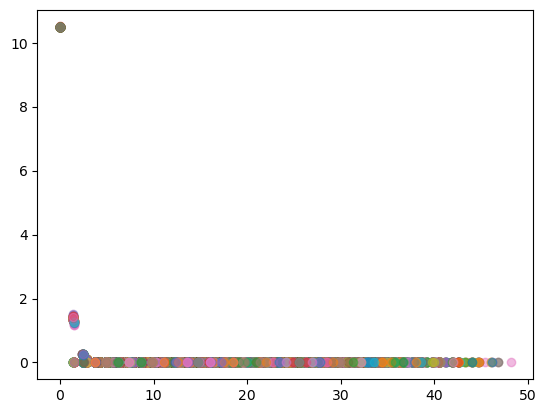

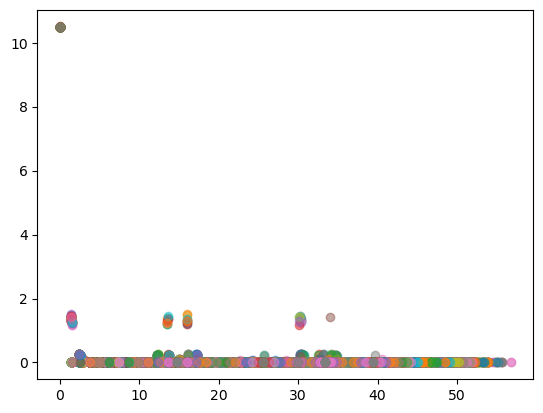

In [ ]:
fig, ax = plt.subplots()

frame = dataset.structures[0]
n1 = np.array([matrix_norm(T, HT[0][T], frame, 5) for T in HT[0]])
x = n1[:, 0]
y = n1[:, 1]
for i in range(72):
    for j in range(i, 72):
        ax.plot(x[:,i,j], y[:,i,j], 'o', label = f'{i}-{j}', alpha = 0.5)
# ax.legend()
# ax.set_xlim(0,11)

fig, ax = plt.subplots()

frame = dataset.structures[0]
n1 = np.array([matrix_norm(T, dataset.fock_realspace[0][T], frame, 5) for T in dataset.fock_realspace[0]])
x = n1[:, 0]
y = n1[:, 1]
for i in range(72):
    for j in range(i, 72):
        ax.plot(x[:,i,j], y[:,i,j], 'o', label = f'{i}-{j}', alpha = 0.5)
# ax.legend()
# ax.set_xlim(0,11)
# ax.set_ylim(0,1)


# Features

In [ ]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
import rascaline
max_radial  = 6
max_angular = 6
atomic_gaussian_width = 0.3
spline_basis = False
##---splined basis 
if spline_basis:
    spliner = rascaline.utils.SoapSpliner(
        cutoff=cutoff,
        max_radial=max_radial,
        max_angular=max_angular,
        basis=rascaline.utils.SphericalBesselBasis(
            cutoff=cutoff, max_radial=max_radial, max_angular=max_angular
        ),
        density=rascaline.utils.GaussianDensity(atomic_gaussian_width=atomic_gaussian_width),
        accuracy=1e-5,
    )
    splined_basis = spliner.compute()
##-------
hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": splined_basis if spline_basis else {"Gto": {}},
               # "radial_basis": splined_basis,
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

# rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
#                       kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
#                       T_dict = dataset._translation_dict)

def compute_features(dataset):
    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = False,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij, counter = None, 
                          T_dict = None)

    # rhoij_blocks = []
    # for k, b in rhoij.items():
    #     values = []
    #     samples = []
    #     for iss, s in enumerate(b.samples):
    #         if s['cell_shift_a'] == 0 and s['cell_shift_b'] == 0 and s['cell_shift_c'] == 0 and s['sign'] == 1:
    #             values.append(b.values[iss])
    #             samples.append(s.values[:-4])
    #     rhoij_blocks.append(TensorBlock(samples = Labels(b.samples.names[:-4], np.array(samples)),
    #                                     components = b.components,
    #                                     properties = b.properties,
    #                                     values = torch.from_numpy(np.array(values))))
    # rhoij = TensorMap(rhoij.keys, rhoij_blocks)
    
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)
    # hfeat = twocenter_hermitian_features(single_center = rhonui, pair = rhoij)
    # hfeat = hfeat.keys_to_samples('cell_shift_a')
    # hfeat = hfeat.keys_to_samples('cell_shift_b')
    # hfeat = hfeat.keys_to_samples('cell_shift_c')
    return hfeat

In [ ]:
hfeat = compute_features(dataset)
# hfeat = target_blocks.to(arrays='numpy')
# target_blocks = sort(target_blocks)
# target_blocks = target_blocks.to(arrays='torch')

{'cutoff': 6, 'max_radial': 6, 'max_angular': 6, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}
torch.Size([2880, 1, 6]) 1
torch.Size([5688, 1, 6]) 2
torch.Size([2880, 3, 6]) 1
torch.Size([5688, 3, 6]) 2
torch.Size([2880, 5, 6]) 1
torch.Size([5688, 5, 6]) 2
torch.Size([2880, 7, 6]) 1
torch.Size([5688, 7, 6]) 2
torch.Size([2880, 9, 6]) 1
torch.Size([5688, 9, 6]) 2
torch.Size([2880, 11, 6]) 1
torch.Size([5688, 11, 6]) 2
torch.Size([2880, 13, 6]) 1
torch.Size([5688, 13, 6]) 2


In [ ]:
for k, b in hfeat.items():
    print(b.values.shape)

torch.Size([72, 1, 252])
torch.Size([72, 3, 432])
torch.Size([72, 5, 576])
torch.Size([72, 7, 648])
torch.Size([72, 3, 216])
torch.Size([72, 5, 360])
torch.Size([72, 7, 468])
torch.Size([1404, 1, 144])
torch.Size([1404, 1, 144])
torch.Size([1404, 3, 252])
torch.Size([1404, 3, 252])
torch.Size([1404, 5, 324])
torch.Size([1404, 5, 324])
torch.Size([1404, 7, 360])
torch.Size([1404, 7, 360])
torch.Size([1404, 3, 108])
torch.Size([1404, 3, 108])
torch.Size([1404, 5, 180])
torch.Size([1404, 5, 180])
torch.Size([1404, 7, 216])
torch.Size([1404, 7, 216])


In [ ]:
from mlelec.features.acdc_utils import _pca
hfeat_pca = _pca(hfeat, npca = 19)

# Train

## Ridge regression

In [ ]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'

In [ ]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [ ]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-20, 1, 100),
                                                                         # alphas = np.logspace(-30, -6, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(82.0404)


In [ ]:
from mlelec.utils.plot_utils import plot_block_errors

(1e-16, 645.9332869861036)

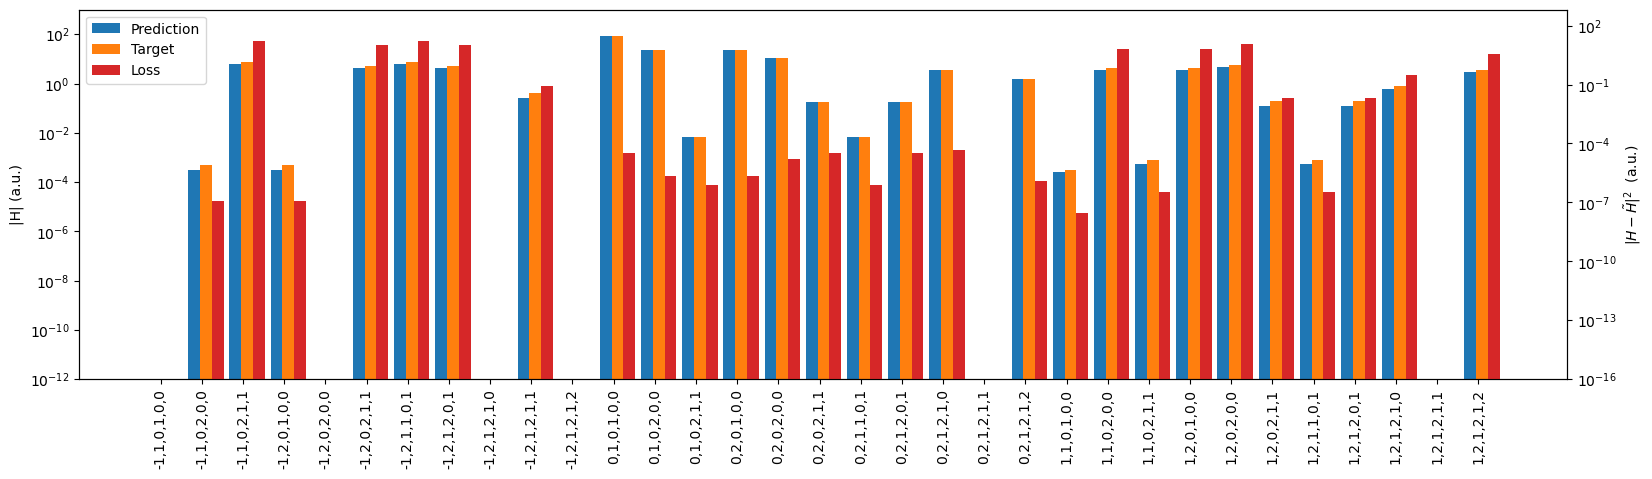

In [ ]:
fig, ax, ax_l = plot_block_errors(target_coupled_blocks, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-12,)
ax_l.set_ylim(1e-16,)


In [ ]:
for i, ((kt, bt), (kp, bp)) in enumerate(zip(target_coupled_blocks.items(), pred_ridge_bias.items())):
    if i == 2:
        norms = torch.norm(bt.values - bp.values, dim = (1,2))
        for sample, norm in zip(bt.samples.values, norms):
            print(sample, f'{norm.item():.3f}')

[0 0 1 0 0 0] 0.418
[0 0 2 0 0 0] 0.024
[0 0 3 0 0 0] 0.005
[0 0 4 0 0 0] 0.004
[0 0 5 0 0 0] 0.001
[ 0  0  6  0 -1  0] 0.002
[0 0 6 0 0 0] 0.002
[ 0  0  7  0 -1  0] 0.000
[ 0  0  8  0 -1  0] 0.002
[ 0  0  9  0 -1  0] 0.003
[ 0  0 10  0 -1  0] 0.034
[ 0  0 11  0 -1  0] 0.272
[ 0  0 12  0  0  0] 0.021
[ 0  0 13  0  0  0] 0.412
[ 0  0 14  0  0  0] 0.016
[ 0  0 15  0  0  0] 0.000
[ 0  0 16  0  0  0] 0.000
[ 0  0 17  0  0  0] 0.002
[ 0  0 18  0  0  0] 0.001
[ 0  0 19  0 -1  0] 0.002
[ 0  0 19  0  0  0] 0.001
[ 0  0 20  0 -1  0] 0.002
[ 0  0 21  0 -1  0] 0.003
[ 0  0 22  0 -1  0] 0.001
[ 0  0 23  0 -1  0] 0.004
[ 0  0 24  0  0  0] 0.003
[ 0  0 25  0  0  0] 0.001
[ 0  0 26  0  0  0] 0.002
[ 0  0 27  0  0  0] 0.013
[ 0  0 28  0  0  0] 0.008
[ 0  0 29  0  0  0] 0.002
[ 0  0 30  0  0  0] 0.004
[ 0  0 31  0  0  0] 0.003
[ 0  0 33  0 -1  0] 0.002
[ 0  0 34  0 -1  0] 0.001
[ 0  0 35  0 -1  0] 0.000
[ 0  0 36 -1  0  0] 0.000
[ 0  0 36  0  0  0] 0.001
[ 0  0 37  0  0  0] 0.000
[ 0  0 38  0  0  0] 0.

## Torch

In [ ]:
from mlelec.metrics import L2_loss, L2_kspace_loss

In [ ]:
from mlelec.models.linear import LinearModelPeriodic

In [ ]:
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.symmetry import ClebschGordanReal
target_kspace = dataset.fock_kspace #orch.stack([kfock[ifr][:1] for ifr in range(3)])
CG = ClebschGordanReal(lmax = 3, device = device)

In [125]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            nhidden = 128, 
                            nlayers = 2,
                            train_kspace = False,
                            activation = 'SiLU',
                            apply_norm = False
                           )

model = model.double()
# for p, (_, b) in zip(model.parameters(), target_coupled_blocks.items()):
#     p.data = torch.ones_like(p.data)

losses = {}
para = {}
grad = {}
learning_rates = {}
nepoch = 10000

# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=50, verbose=True)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 400, 600, 800], gamma=1e-1)
optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))
    # schedulers.append(torch.optim.lr_scheduler.MultiStepLR(optimizers[-1], milestones=[2000, 4000, 6000, 8000], gamma=1e-1, verbose = False))
    

In [126]:
# kpts_train = [dataset_cp2k.kpts_rel[ifr][:] for ifr in range(len(dataset_cp2k.structures))]

# nk = len(kpts_train[0])
# target_kspace = [x[:nk] for x in dataset_cp2k.fock_kspace]

kpts_train = [dataset.kpts_rel[ifr][:] for ifr in range(len(dataset.structures))]

nk = len(kpts_train[0])
target_kspace = [x[:nk] for x in dataset.fock_kspace]

In [127]:
kpts_ = torch.from_numpy(np.array(kpts_train)).to(device)

# nepoch = 10000

new_sched = True
# epoch = 2000
for epoch in range(nepoch):
    # epoch = epoch_+2000
    
    model.train(True)

    # for ik, key in enumerate(model.model):
    #     optimizers[ik].zero_grad()
    optimizer.zero_grad()
    
    # epoch_loss = 0
    pred = model()
    n_predictions = sum([np.prod(b.values.shape) for _, b in pred.items()])

    if epoch < 10:
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
        # epoch_loss.backward()
        # optimizer.step()
        # scheduler.step(epoch_loss)
        epoch_loss = epoch_loss.item()
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), .5)
            optimizers[ik].step()
            # schedulers[ik].step()
            schedulers[ik].step(loss)
            
        # epoch_loss += tot_loss
            # if key not in losses:
            #     losses[key] = [loss.item()]
            #     learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            # else:
            #     losses[key].append(loss.item())
            #     learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
            
    
        # for ik, (key, loss) in enumerate(model.model):
        
    else:
        # if new_sched:
        #     pred_before_k = pred.copy()

        #     optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
        #     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5, patience = 200, verbose=True)
        #     # for s, o in zip(schedulers, optimizers):
        #     #     s = torch.optim.lr_scheduler.ReduceLROnPlateau(o, factor = 0.5, patience = 100, verbose=True)
        #     new_sched = False

        #     _loss = L2_kspace_loss(pred, 
        #                       target_kspace, 
        #                       dataset, 
        #                       cg = CG, 
        #                       kpts = kpts_,
        #                       norm = 1
        #                       )
        #     print("Initial k-space loss = ", _loss.item())
        
        loss = L2_kspace_loss(pred, 
                              target_kspace, 
                              dataset, 
                              cg = CG, 
                              kpts = kpts_,
                              norm = 1
                              ) 

        loss.backward(retain_graph = False)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        epoch_loss = loss.item()
        for key in model.model:
            if key not in losses:
                losses[key] = [epoch_loss/len(model.model)]
            else:
                losses[key].append(epoch_loss/len(model.model))
    
        for ik, key in enumerate(model.model):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss)
        
        # optimizer.step()
        # scheduler.step(epoch_loss)

        for i, key in enumerate(model.model):
            if key not in para:
                para[key] = []
                grad[key] = []
    # optimizers[0].param_groups[0]['lr']
# for param in model.model[key].parameters():
#     grad[key].append(param.grad.norm().item())
#     para[key].append(param.norm().item())


    if epoch % 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

        # for i, key in enumerate(model.model):
        #     if key not in para:
        #         para[key] = []
        #         grad[key] = []
        #         # optimizers[0].param_groups[0]['lr']
        #     for param in model.model[key].parameters():
        #         grad[key].append(param.grad.norm().item())
        #         para[key].append(param.norm().item())

    #     # validate 
    #     valpred = model.predict(hfeat_test, target_test)
    #     if loss_func == 'kspace':
    #         val_loss = L2_kspace_loss(valpred, target_test, dataset)
    #     else:
    #         val_loss = L2_loss(valpred, target_test)
        
    #     print(f"Epoch {epoch} val loss {val_loss}")


Epoch       0, train loss on all blocks 8667.5725853373, train loss per prediction 1.29305e-03
Epoch      10, train loss on all blocks 5646.6334748141, train loss per prediction 1.04367e-03
Epoch      20, train loss on all blocks 3854.6743898722, train loss per prediction 8.62306e-04


KeyboardInterrupt: 

In [ ]:
pred = model()
_, l = L2_loss(pred, target_coupled_blocks, loss_per_block = True)
print(l)

In [ ]:
pred_real = blocks_to_matrix(target_coupled_blocks, dataset)
target_kspace_cutoff = []
for ifr in range(1):
    rH = torch.stack(list(pred_real[ifr].values()))
    T = torch.from_numpy(np.array(list(pred_real[ifr].keys()), dtype = np.float64)).to(rH)
    from mlelec.utils.pbc_utils import inverse_fourier_transform
    kH = inverse_fourier_transform(rH, T_list = T, k = kpts_[ifr], norm = 1)
    target_kspace_cutoff.append(kH)

In [ ]:
l = L2_kspace_loss(pred, target_kspace, 
                              dataset, 
                              cg = CG, 
                              kpts = kpts_,
                              norm = 1) 
print(l)

tensor(0.0107, grad_fn=<SelectBackward0>)


In [ ]:
ifr = 0
pred_real = blocks_to_matrix(pred, dataset)
rH = torch.stack(list(pred_real[ifr].values()))
T = torch.from_numpy(np.array(list(pred_real[ifr].keys()), dtype = np.float64)).to(rH)
from mlelec.utils.pbc_utils import inverse_fourier_transform
kH = inverse_fourier_transform(rH, T_list = T, k = kpts_[ifr], norm = 1)

In [ ]:
err_k = []
for H1, H2 in zip(target_kspace[0], kH):
    print('{:.3e} {:.3e} {:.3e}'.format(torch.norm(H1-H2).item(), torch.norm(H1).item(), torch.norm(H2).item()))
    err_k.append(torch.norm(H1-H2).item())

1.057e-01 1.805e+01 1.799e+01
9.965e-02 1.799e+01 1.794e+01
8.332e-02 1.783e+01 1.779e+01
7.608e-02 1.762e+01 1.758e+01
7.803e-02 1.751e+01 1.748e+01
7.608e-02 1.762e+01 1.758e+01
8.332e-02 1.783e+01 1.779e+01
9.965e-02 1.799e+01 1.794e+01
1.052e-01 1.800e+01 1.794e+01
9.396e-02 1.790e+01 1.784e+01
7.135e-02 1.770e+01 1.766e+01
6.547e-02 1.752e+01 1.749e+01
7.443e-02 1.751e+01 1.747e+01
8.485e-02 1.768e+01 1.763e+01
9.357e-02 1.788e+01 1.783e+01
1.014e-01 1.800e+01 1.794e+01
1.090e-01 1.786e+01 1.778e+01
9.871e-02 1.772e+01 1.764e+01
6.444e-02 1.754e+01 1.749e+01
5.860e-02 1.744e+01 1.741e+01


In [ ]:
from mlelec.utils.pbc_utils import inverse_bloch_sum, fourier_transform, inverse_fourier_transform

In [ ]:
target_kspace[0].shape

torch.Size([64, 10, 10])

In [ ]:
from ase.units import Bohr
dataset.cells[0].rcut *Bohr

8.354813970815703

In [ ]:
matrix = target_kspace[0]
k = torch.from_numpy(kpts_train[0])

for cutoff in [4, 6, 8]:
    
    H_T_6 = inverse_bloch_sum(dataset, matrix, 0, cutoff)
    
    H_T_6_v = torch.stack(list(H_T_6.values()))
    T = torch.from_numpy(np.array(list(H_T_6.keys()), dtype = np.float64)).to(H_T_6_v)
    H_k_6 = inverse_fourier_transform(H_T_6_v, T_list = T, k = k, norm = 1)
    
    print('cutoff =', cutoff, 'error = ', torch.norm(H_k_6 - matrix).item())

cutoff = 4 error =  0.06488659428454661
cutoff = 6 error =  0.039240800225787284
cutoff = 8 error =  0.04525613464388159


In [ ]:
H_T_6 = inverse_bloch_sum(dataset, matrix, 0, 6)
H_T_12 = inverse_bloch_sum(dataset, matrix, 0, 10)

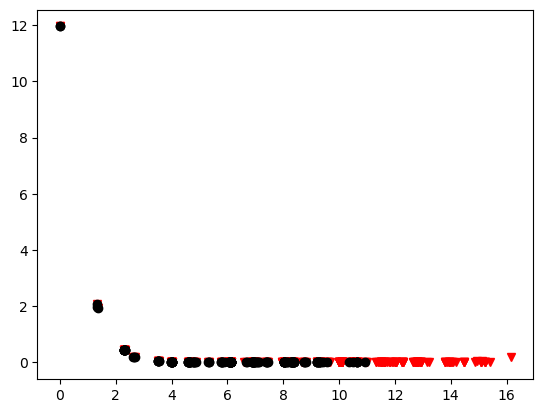

In [ ]:
fig, ax = plt.subplots()

frame = dataset.structures[0]
n1 = np.array([matrix_norm(T, H_T_12[T], frame, 5) for T in H_T_12])
x = n1[:, 0]
y = n1[:, 1]
for i in range(2):
    for j in range(i, 2):
        ax.plot(x[:,i,j], y[:,i,j], 'v', c = 'r')

n1 = np.array([matrix_norm(T, H_T_6[T], frame, 5) for T in H_T_6])
x = n1[:, 0]
y = n1[:, 1]
for i in range(2):
    for j in range(i, 2):
        ax.plot(x[:,i,j], y[:,i,j], 'o', c = 'k')

0.0861365890640978 0.014891071885720399


(array([1., 2., 1., 4., 2., 1., 1., 2., 3., 3.]),
 array([0.05860465, 0.06364184, 0.06867904, 0.07371623, 0.07875343,
        0.08379062, 0.08882782, 0.09386501, 0.09890221, 0.1039394 ,
        0.1089766 ]),
 <BarContainer object of 10 artists>)

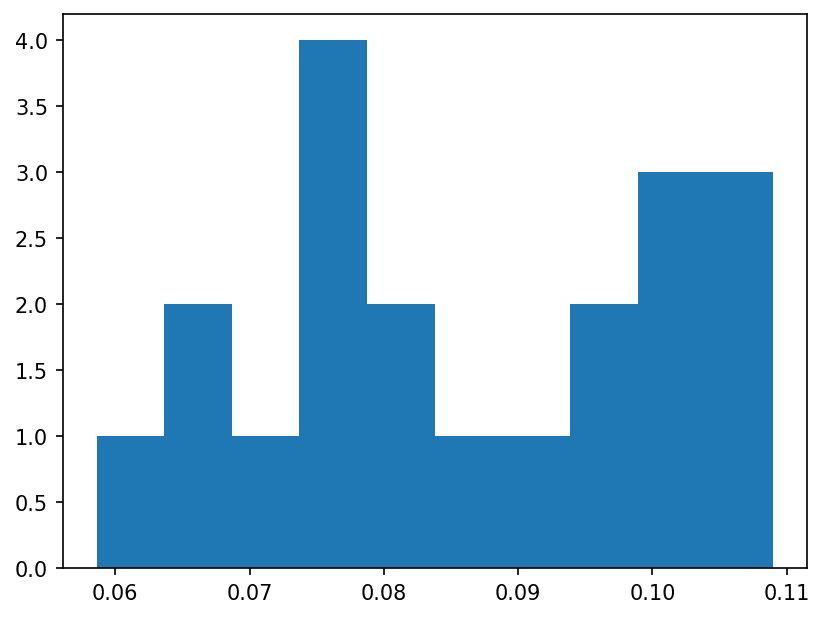

In [ ]:
print(np.mean(err_k), np.std(err_k))
plt.hist(err_k)

Text(0, 0.5, 'loss')

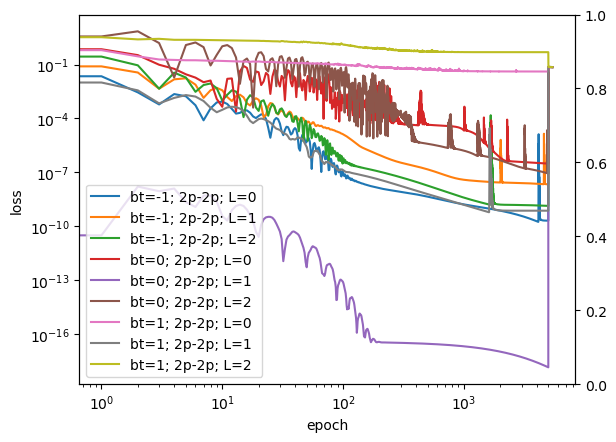

In [ ]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()
ax_lr = ax.twinx()
for key in losses:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 2 and l2 == 1: # and L == 0:
    # if True:
        y = []
        for l in losses[key]:
            try:
                y.append(l.detach().numpy())
            except AttributeError:
                y.append(l)
        pl, = ax.loglog(np.arange(len(losses[key])), y, '-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
        # ax_lr.loglog(np.arange(len(learning_rates[key])), learning_rates[key], '--', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}', color = pl.get_color())
ax.legend(loc = 'lower left')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
# ax_lr.set_ylabel('learning rate')

In [ ]:
from mlelec.utils.pbc_utils import blocks_to_matrix

In [ ]:
len(blocks_to_matrix(pred_before_k, dataset)[0])

51

In [ ]:
len(blocks_to_matrix(pred, dataset)[0])

51

In [ ]:
def reconstruct(pred, dataset, cutoff):
    from mlelec.utils.pbc_utils import inverse_bloch_sum
    reconstructed_H_ = blocks_to_matrix(pred, dataset)
    reconstructed_H = []
    reconstructed_S = []
    S = [inverse_bloch_sum(dataset, dataset.overlap_kspace[ifr], ifr, cutoff) for ifr in range(len(dataset.structures))]
    for ifr in range(len(reconstructed_H_)):
        reconstructed_H.append({})
        reconstructed_S.append({})
        for T in reconstructed_H_[ifr]:
            if T in S[ifr]:
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            elif tuple(-np.array(T)) in S[ifr]:
                T = tuple(-np.array(T))
                reconstructed_S[ifr][T] = S[ifr][T]
                reconstructed_H[ifr][T] = reconstructed_H_[ifr][T].cpu().detach().numpy()
            else:
                print(T)
                raise ValueError()
    return reconstructed_H, reconstructed_S

In [ ]:
# rH_r, rS_r = reconstruct(pred_before_k, dataset, cutoff = cutoff)
rH_k, rS_k = reconstruct(pred, dataset, cutoff = cutoff)

_, true_target_coupled_blocks = get_targets(dataset, cutoff = 12, device = device)
rH_true, rS_true = reconstruct(true_target_coupled_blocks, dataset, cutoff = 12)

-0.028305136685198552
-0.03062389543744466


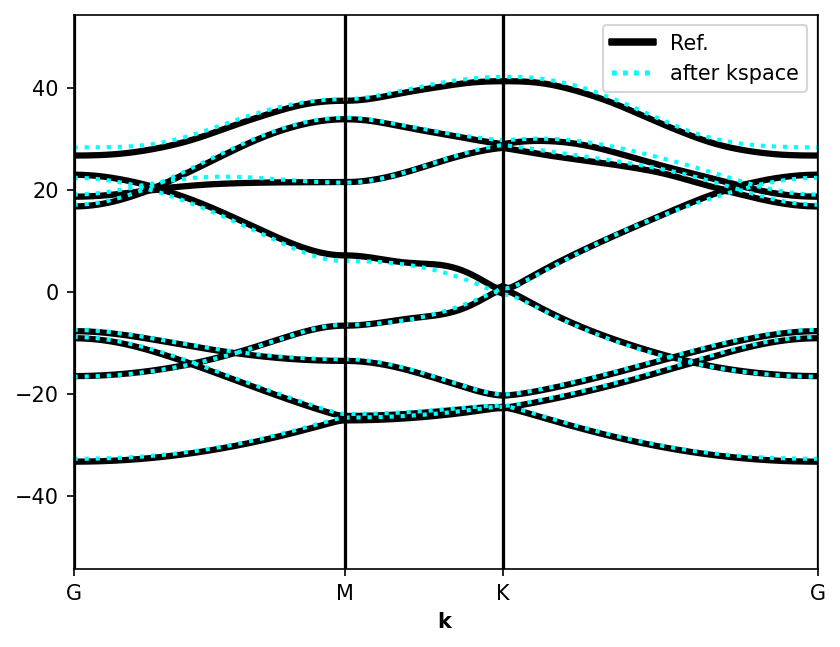

In [ ]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(rH_true[0].values())) #np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(rS_true[0].values())) #np.asarray(list(dataset.overlap_realspace[0].values()))
R_vec_rel = [list(T) for T in rH_true[0]]

handles = []
labels = []

ax, b, handle = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh, special_symm = 'hexagonal', 
                                  factor = 1,
                                  kpath = kpath, ax = ax, color = 'k', R_vec_rel_in = R_vec_rel, lw = 3)
handles.append(tuple(handle))
labels.append('Ref.')

for H, S, c, ls, factor, label in zip([rH_r, rH_k], [rS_r, rS_k], ['red', 'cyan'], ['--', ':'], [1, 1], ['only real space', 'after kspace']): #np.sqrt(np.prod(kmesh)/len(H[0]))]):
    if label == 'only real space':
        continue
    realfock_cutoff = np.asarray(list(H[0].values()))
    realover_cutoff = np.asarray(list(S[0].values()))
    R_vec_rel = [list(T) for T in H[0]]
    ax, b, handle = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh, 
                                      factor = factor,
                                      lw = 2,
                                      R_vec_rel_in = R_vec_rel, special_symm = 'hexagonal', kpath = kpath, ax = ax, color = c, ls = ls)
    handles.append(tuple(handle))
    labels.append(label)

ax.legend(handles, labels)
# ax.set_ylim(-35, 43)
# nmax = 50
# for ifr in range(0, nmax):
#     frame = dataset.structures[ifr]
#     pyscf_cell = dataset.cells[ifr]
#     kmesh = dataset.kmesh[ifr]
#     kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
#     realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
#     realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
#     realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
#     realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
#     fig, ax = plt.subplots()
#     ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
#     ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
#                               kpath = kpath, ax = ax, color = 'k', ls = ':')



(1900, 2500)

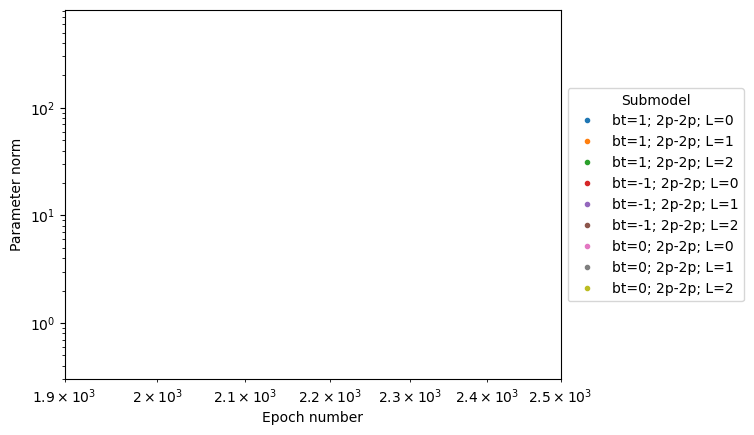

In [ ]:
o = {0: 's', 1: 'p'}

fig, ax = plt.subplots()

for key in para:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if n1 == 2 and l1 == 1 and n2 == 2 and l2 == 1:
        ax.loglog(np.arange(len(para[key]))*10, para[key], '.', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(title = 'Submodel', loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Parameter norm')
ax.set_xlim(1900, 2500)

Text(0, 0.5, 'Gradient norm')

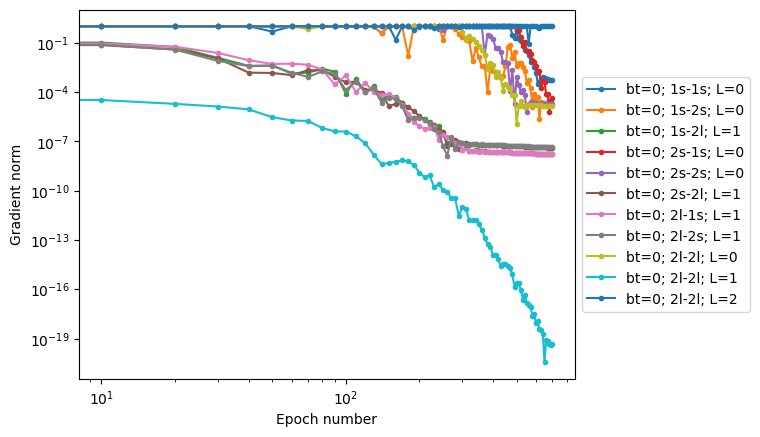

In [ ]:
o = {0: 's', 1: 'l'}

fig, ax = plt.subplots()

for key in grad:
    bt, _, n1, l1, _, n2, l2, L = np.int32(key[1:-1].split(','))
    if bt == 0:
        ax.loglog(np.arange(len(grad[key]))*10, grad[key], '.-', label = f'bt={bt}; {n1}{o[l1]}-{n2}{o[l2]}; L={L}')
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
ax.set_xlabel('Epoch number')
ax.set_ylabel('Gradient norm')
# ax.set_xlim(800)


# TODO: build model for 1s-1s interaction

In [ ]:
weights = {}
for i, p in enumerate(model.parameters()):
    # if i//2 not in weights:
        # weights[i//2] = {}
        # weights[i//2][0] = p.data
    # else:
        # weights[i//2][1] = p.data
    weights[i] = p.data

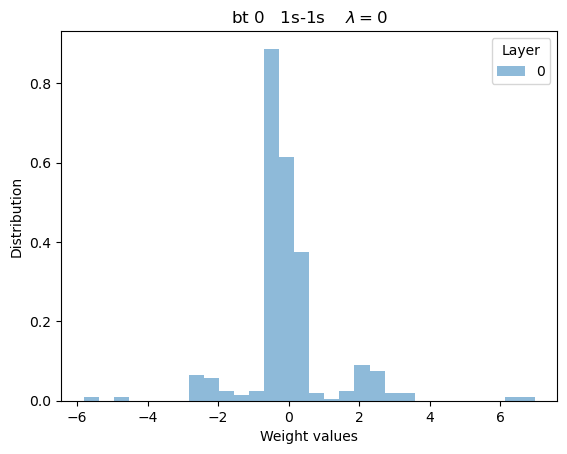

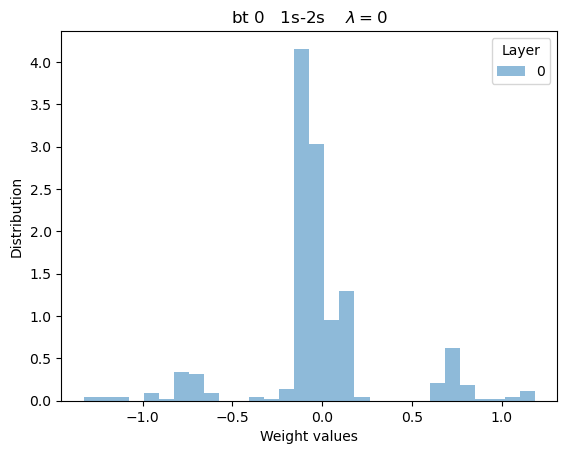

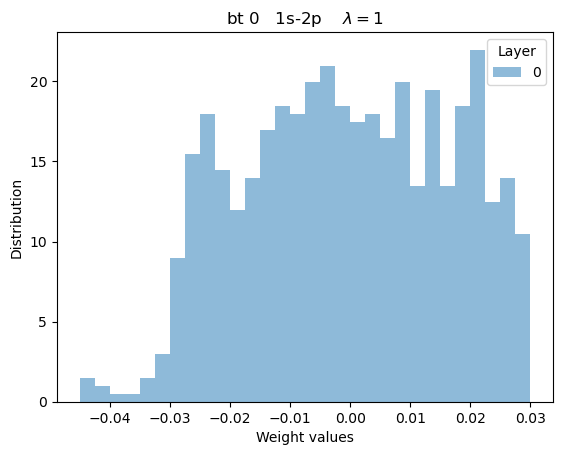

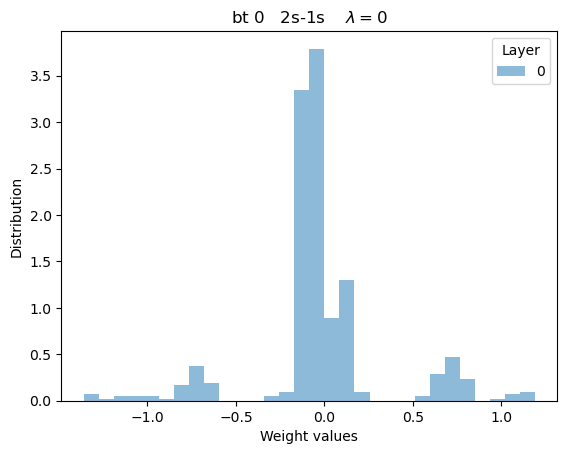

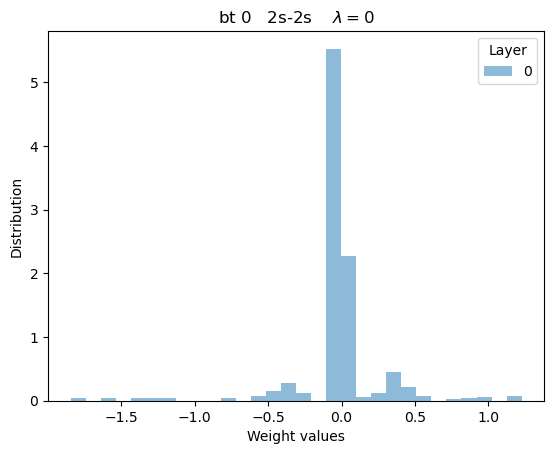

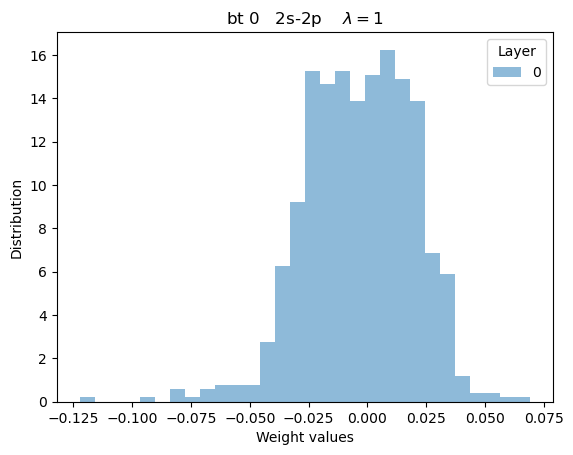

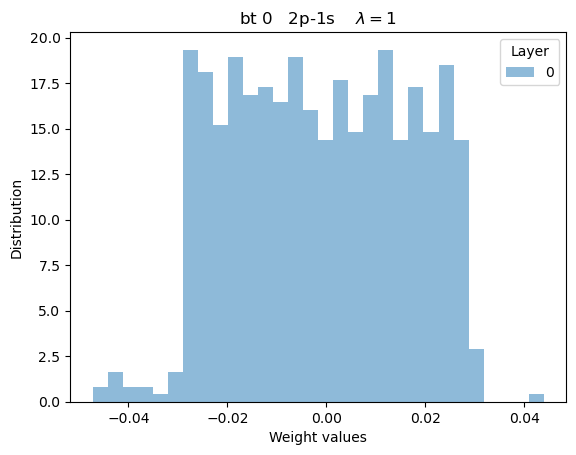

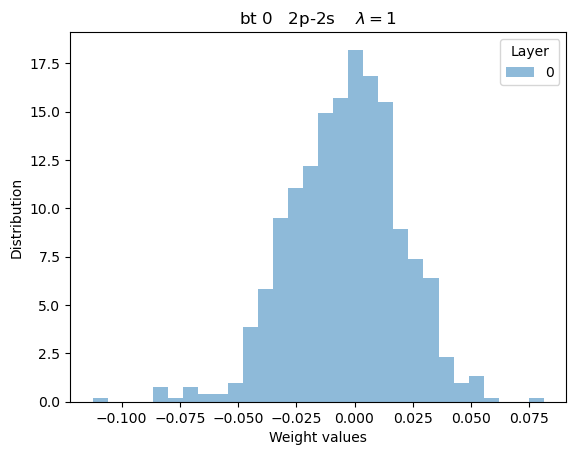

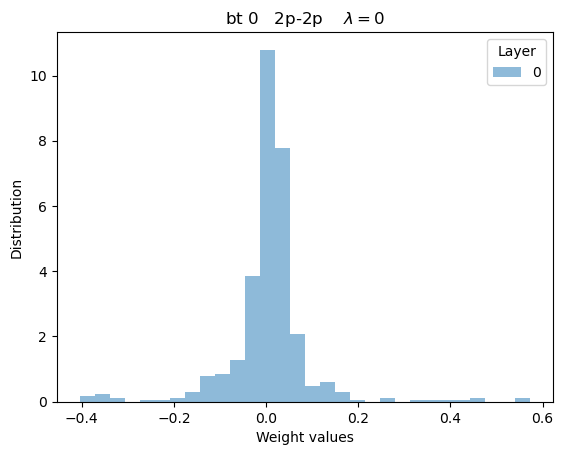

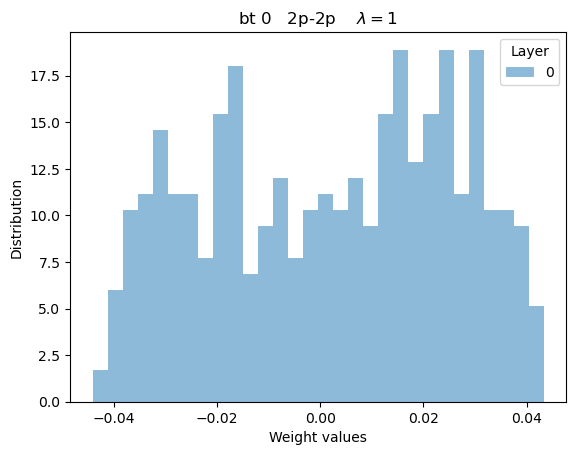

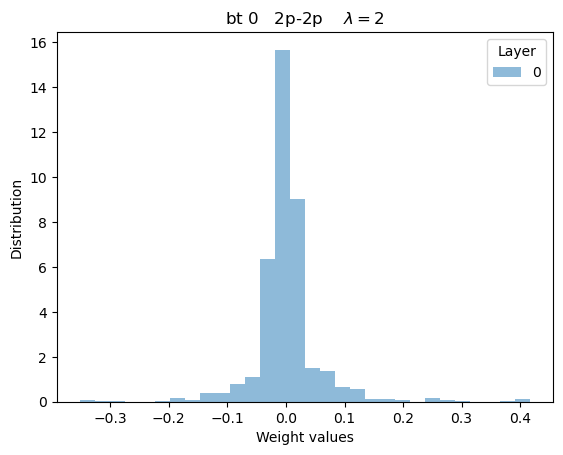

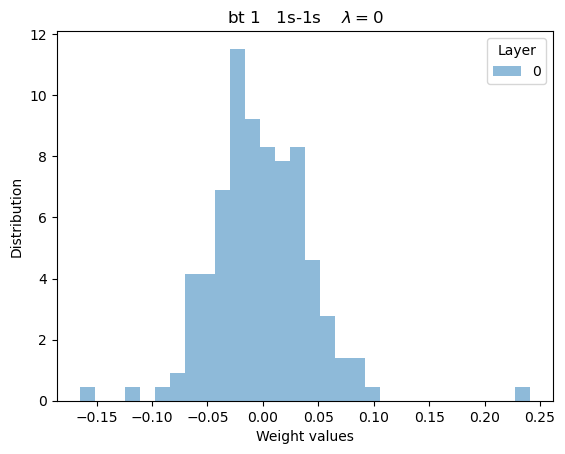

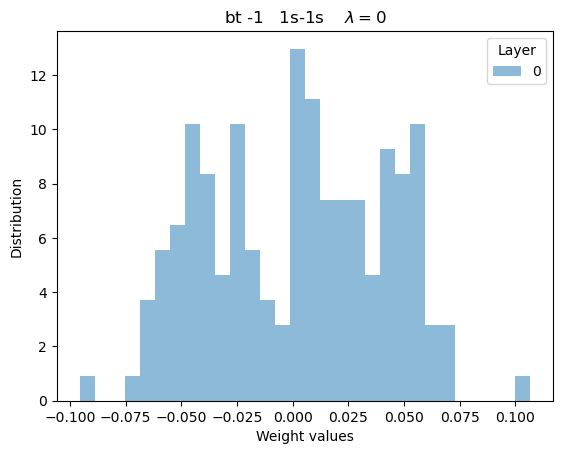

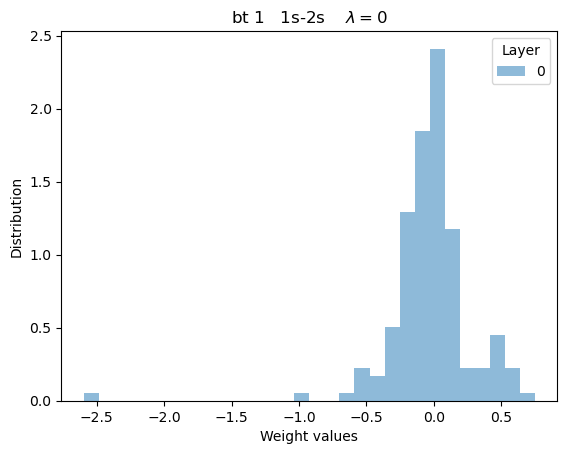

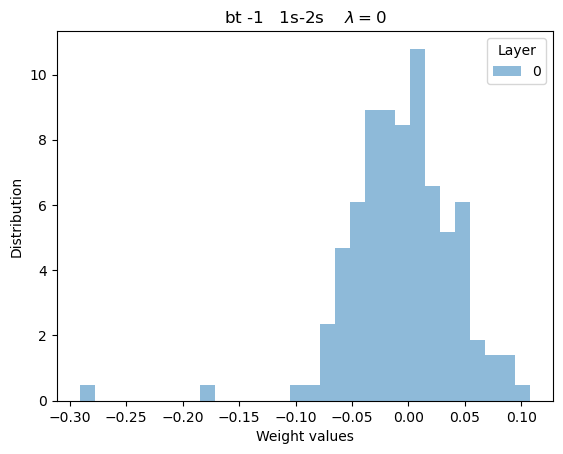

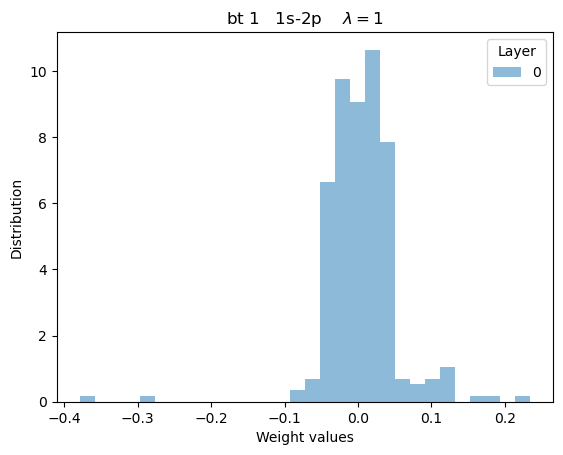

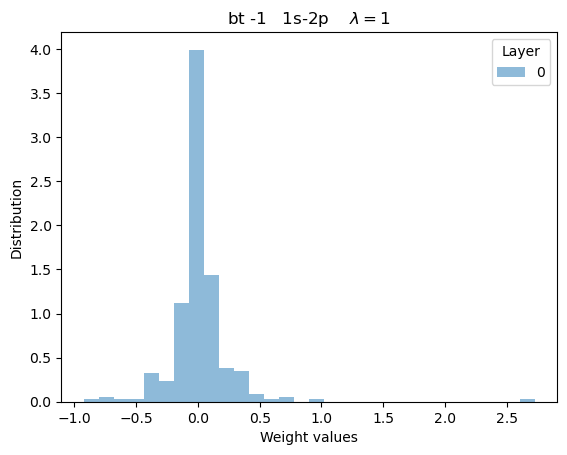

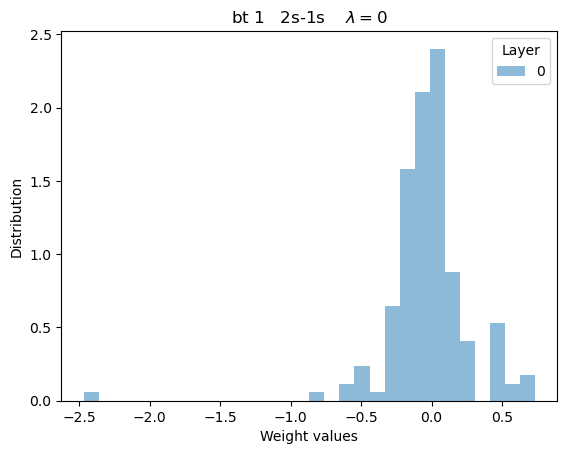

In [ ]:
orb_labels = {0: 's', 1: 'p', 2: 'd'}
for i in range(18):
    fig, ax = plt.subplots()
    bt, _, n0, l0, _, n1, l1, L = pred.keys[i].values
    title = f'bt {bt}   {n0}{orb_labels[l0]}-{n1}{orb_labels[l1]}    $\lambda={L}$'
    # for j in range(1):
        # ax.hist(weights[i][j].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.hist(weights[i].flatten().detach().cpu(), alpha = 0.5, density = True, bins = 30, label = j)
    ax.set_title(title)
    ax.legend(title='Layer')
    ax.set_xlabel('Weight values')
    ax.set_ylabel('Distribution')

In [ ]:
for k, b in hfeat.items():
    print()
    print(k)
    for sample in b.values:
        print('{:.3f} {:.3f}'.format(torch.norm(sample).item(), torch.var(sample).item()))


LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=0, species_center=6, species_neighbor=6, block_type=0)
3.234 0.017
3.234 0.017

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.157 0.000
0.157 0.000

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
4.121 0.003
4.121 0.003

LabelsEntry(order_nu=2, inversion_sigma=1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
3.600 0.002
3.600 0.002

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=1, species_center=6, species_neighbor=6, block_type=0)
0.004 0.000
0.004 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=2, species_center=6, species_neighbor=6, block_type=0)
0.101 0.000
0.101 0.000

LabelsEntry(order_nu=2, inversion_sigma=-1, spherical_harmonics_l=3, species_center=6, species_neighbor=6, block_type=0)
0.149 

In [ ]:
target_kspace[0].shape

torch.Size([64, 10, 10])

In [ ]:
for k, b in target_coupled_blocks.items():
    print()
    print(k)
    # for sample in b.values:
    #     print('{:.3e} {:.3e}'.format(torch.norm(sample).item(), torch.var(sample).item()))
    # print(np.mean([torch.norm(feature).item() for feature in b.values]), np.std([torch.norm(sample).item() for sample in b.values]))
    print('{:.3e} {:.3e}'.format(torch.norm(b.values, dim = 2).mean().item(), torch.norm(b.values, dim = 2).std().item()))


LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
1.102e+01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=1, l_j=0, L=0)
2.976e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=0, L=0)
1.733e+00 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=0, species_j=6, n_j=2, l_j=1, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=1, l_j=0, L=1)
4.743e-04 2.018e-04

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=0, L=1)
9.066e-03 4.359e-03

LabelsEntry(block_type=0, species_i=6, n_i=2, l_i=1, species_j=6, n_j=2, l_j=1, L=0)
7.948e-01 0.000e+00

LabelsEntry(block_type=0, species_i=6, n_i=2,

In [ ]:
b.values.norm(dim=2).mean(dim=0)

tensor([3.2785e-11, 4.8314e-13, 1.6071e-16, 1.6817e-12, 1.4629e-16],
       device='cuda:0')

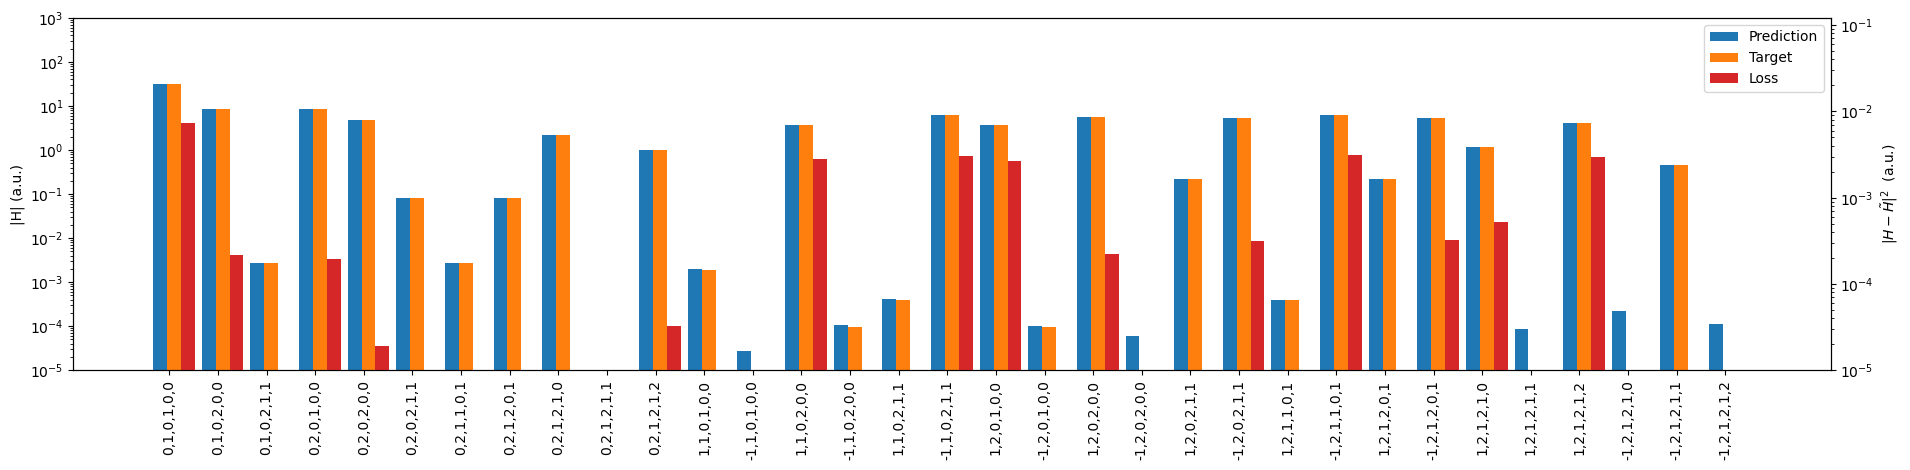

In [ ]:
from mlelec.utils.plot_utils import plot_block_errors
fig,ax,ax_loss=plot_block_errors(target_coupled_blocks_c, pred_before_k, plot_loss = True)
ax_loss.set_ylim(1e-5,)
ax.set_ylim(1e-5,)
fig.tight_layout()

In [ ]:
f0 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/realfock_0.npy', allow_pickle=True).item()
f1 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/realfock_1.npy', allow_pickle=True).item()
f2 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/realfock_2.npy', allow_pickle=True).item()

fk0 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/fock_0.npy')
fk1 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/fock_1.npy')
ok0 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/overlap_0.npy')
ok1 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/overlap_1.npy')
fk2 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/fock_2.npy')
ok2 = np.load('/home/pegolo/Software/my_mlelec/examples/data/periodic/c2/cp2k/graphene_supercell_variety/overlap_2.npy')

In [ ]:
def print_matrix(matrix):
    for row in matrix:
        for v in row:
            print(f'{v:>15.10f}', end = ' ')
        print()

In [ ]:
print_matrix(f0[0,0,0])
print()
# print_matrix(f1[0,0,0][:4,4:8])

   1.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0236002500   -0.0000000000    0.0000000000    0.0643940208 
  -0.0000000000    1.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0277453094    0.0000000000    0.0000000000 
   0.0000000000    0.0000000000    1.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0277453094    0.0000000000 
   0.0000000000    0.0000000000    0.0000000000    1.0000000000   -0.0643940208    0.0000000000    0.0000000000   -0.1006517391 
   0.0236002500    0.0000000000    0.0000000000   -0.0643940208    1.0000000000    0.0000000000    0.0000000000    0.0000000000 
  -0.0000000000    0.0277453094    0.0000000000    0.0000000000    0.0000000000    1.0000000000    0.0000000000    0.0000000000 
   0.0000000000    0.0000000000    0.0277453094    0.0000000000    0.0000000000    0.0000000000    1.0000000000    0.0000000000 
   0.0643940208    0.0000000000    0.0000000000   -0.1006517391    0.0000000000    0.0000000000  

In [ ]:
from mlelec.utils.twocenter_utils import lowdin_orthogonalize

In [ ]:
ok0[1].dtype

dtype('complex128')

In [ ]:
from scipy.linalg import eigh
e1,v1 = eigh(fk0[1], ok0[1])

e2,v2 = eigh(lowdin_orthogonalize(torch.from_numpy(fk0[1]), torch.from_numpy(ok0[1])).numpy())

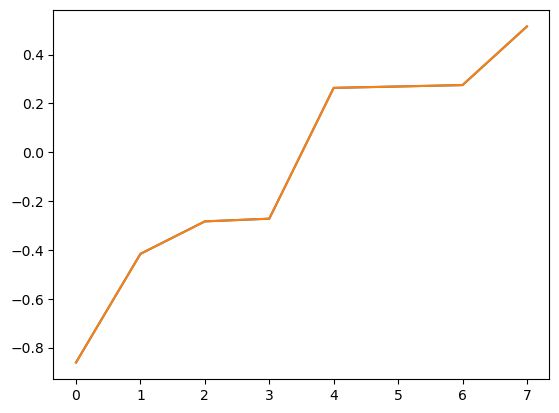

In [ ]:
plt.plot(e1)
plt.plot(e2)


In [ ]:
fk0_L = lowdin_orthogonalize(torch.from_numpy(fk0[1]), torch.from_numpy(ok0[1])).numpy()
fk1_L = lowdin_orthogonalize(torch.from_numpy(fk1[1]), torch.from_numpy(ok1[1])).numpy()
fk2_L = lowdin_orthogonalize(torch.from_numpy(fk1[2]), torch.from_numpy(ok1[2])).numpy()

In [ ]:
fk0_L = []
for H, S in zip(fk0, ok0):
    fk0_L.append(lowdin_orthogonalize(torch.from_numpy(H), torch.from_numpy(S)))
fk0_L = torch.stack(fk0_L)

In [ ]:
fk1_L = []
for H, S in zip(fk1, ok1):
    fk1_L.append(lowdin_orthogonalize(torch.from_numpy(H), torch.from_numpy(S)))
fk1_L = torch.stack(fk1_L)

In [ ]:
fk2_L = []
for H, S in zip(fk2, ok2):
    fk2_L.append(lowdin_orthogonalize(torch.from_numpy(H), torch.from_numpy(S)))
fk2_L = torch.stack(fk2_L)

In [ ]:
np.all(np.isclose(dataset.kpts_rel[0][1], dataset.kpts_rel[0]), axis = 1)

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
print_matrix(fk0[1,:4,4:8].real)
print()
print_matrix(fk1[1,:4,4:8].real)

print()

print_matrix(fk0_L[:4,4:8].real)
print()
print_matrix(fk1_L[:4,4:8].real)


  -0.9878515796   -0.0800467627    0.0000000000   -0.0462150003 
   0.0800467627    0.1181266971   -0.0000000000   -0.0085594727 
   0.0000000000    0.0000000000   -0.4762380755    0.0000000000 
   0.0462150003   -0.0085594727   -0.0000000000    0.1280103044 

  -0.3344110960    0.0052638579    0.0000000000    0.3327806242 
  -0.0052639452   -0.1717375564    0.0000000000   -0.0091194348 
   0.0000000000   -0.0000000000   -0.1581302846   -0.0000000000 
  -0.3327943547   -0.0091194099    0.0000000000    0.2059891297 

  -0.6108714882   -0.0506358411   -0.0000000000   -0.0292345260 
   0.0392053988    0.2291441567    0.0000000000    0.0164509568 
   0.0000000000   -0.0000000000   -0.3218778276    0.0000000000 
   0.0226350578    0.0164513137    0.0000000000    0.2101469646 

  -0.2034974592    0.0012472539    0.0000000000    0.2834257906 
  -0.0034677505   -0.1471476420   -0.0000000000   -0.0006998841 
  -0.0000000000    0.0000000000   -0.1127855303   -0.0000000000 
  -0.2674010277   -0.0

In [ ]:
workdir = './'
root = f'{workdir}/examples/data/periodic'
ORBS = 'gthszvmolopt'
START = 0
STOP = 3
frames = read(f'{root}/c2/cp2k/graphene_supercell_variety/graphene_variety.xyz', slice(START, STOP))
for f in frames: 
    f.pbc = [True, True, True]

kmesh = [[12,12,1], [6,6,1], [4,4,1]]

kfock = [fk0_L_resh_new.reshape(144,8,8).numpy(), fk1_L.numpy(), fk2_L.numpy()]
# kover = [fk0_L.numpy(), fk1_L.numpy()]

# for ifr in range(len(frames)):
#     for ik, k in enumerate(kfock[ifr]):
#         kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        # kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames[:1], kmesh = kmesh[:1], 
                                    dimension = 2,
                                    fock_kspace = [kfock[ifr][:1] for ifr in range(len(frames[:1]))], 
                                    # overlap_kspace = [kover[ifr][:] for ifr in range(len(frames))],
                                    device = device, orbs = orbitals[ORBS], orbs_name = ORBS)

WARNING!
  Very diffused basis functions are found in the basis set. They may lead to severe
  linear dependence and numerical instability.  You can set  cell.exp_to_discard=0.1
  to remove the diffused Gaussians whose exponents are less than 0.1.

/home/pegolo/Software/my_mlelec/src/mlelec/data/dataset.py:824: UserWarning: Overlap matrices not provided
  warnings.warn("Overlap matrices not provided")


In [ ]:
from metatensor import sort
from ase.units import Bohr
cutoff = 6 #dataset.cells[0].rcut*Bohr
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False)
target_coupled_blocks = target_coupled_blocks.to(arrays='numpy')
target_coupled_blocks = sort(target_coupled_blocks)
target_coupled_blocks = target_coupled_blocks.to(arrays='torch')
target_blocks = target_blocks.to(arrays='numpy')
target_blocks = sort(target_blocks)
target_blocks = target_blocks.to(arrays='torch')

tensor(7.1842e-16)
tensor(1.2992e-16)
tensor(1.1126e-16)
tensor(1.9723e-16)
tensor(9.3908e-17)
tensor(2.8904e-17)
tensor(1.4709e-16)
tensor(3.5006e-16)
tensor(7.6973e-17)
tensor(4.5069e-17)
tensor(4.1822e-17)
tensor(4.4785e-17)
tensor(2.0759e-16)
tensor(1.9756e-16)
tensor(2.1342e-16)
tensor(3.7064e-17)
tensor(2.1251e-17)
tensor(6.5931e-18)
tensor(1.5125e-16)
tensor(4.0182e-16)
tensor(2.7785e-16)
tensor(1.6736e-16)
tensor(8.0640e-17)
tensor(1.2326)
tensor(8.0640e-17)
tensor(1.6736e-16)
tensor(2.7785e-16)
tensor(4.0182e-16)
tensor(1.5125e-16)
tensor(6.5931e-18)
tensor(2.1251e-17)
tensor(3.7064e-17)
tensor(2.1342e-16)
tensor(1.9756e-16)
tensor(2.0759e-16)
tensor(4.4785e-17)
tensor(9.7491e-17)
tensor(4.5069e-17)
tensor(7.6973e-17)
tensor(3.5006e-16)
tensor(1.3561e-16)
tensor(2.5256e-17)
tensor(8.4116e-17)
tensor(1.5177e-16)
tensor(1.1608e-16)
tensor(1.0942e-16)
tensor(7.1379e-16)


In [ ]:
HT = blocks_to_matrix(target_blocks, dataset)

In [ ]:
print_matrix(HT[0][2,0,0][:8,:8])

   0.0000000000   -0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000 
  -0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000 
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000 
  -0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000 
   0.0000000000   -0.0000000000   -0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000 
  -0.0000000000   -0.0000000000   -0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000   -0.0000000000 
  -0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000000   -0.0000000000    0.0000000000   -0.0000000000 
  -0.0000000000   -0.0000000000   -0.0000000000   -0.0000000000    0.0000000000   -0.0000000000  

In [ ]:
from mlelec.utils.plot_utils import plot_hamiltonian

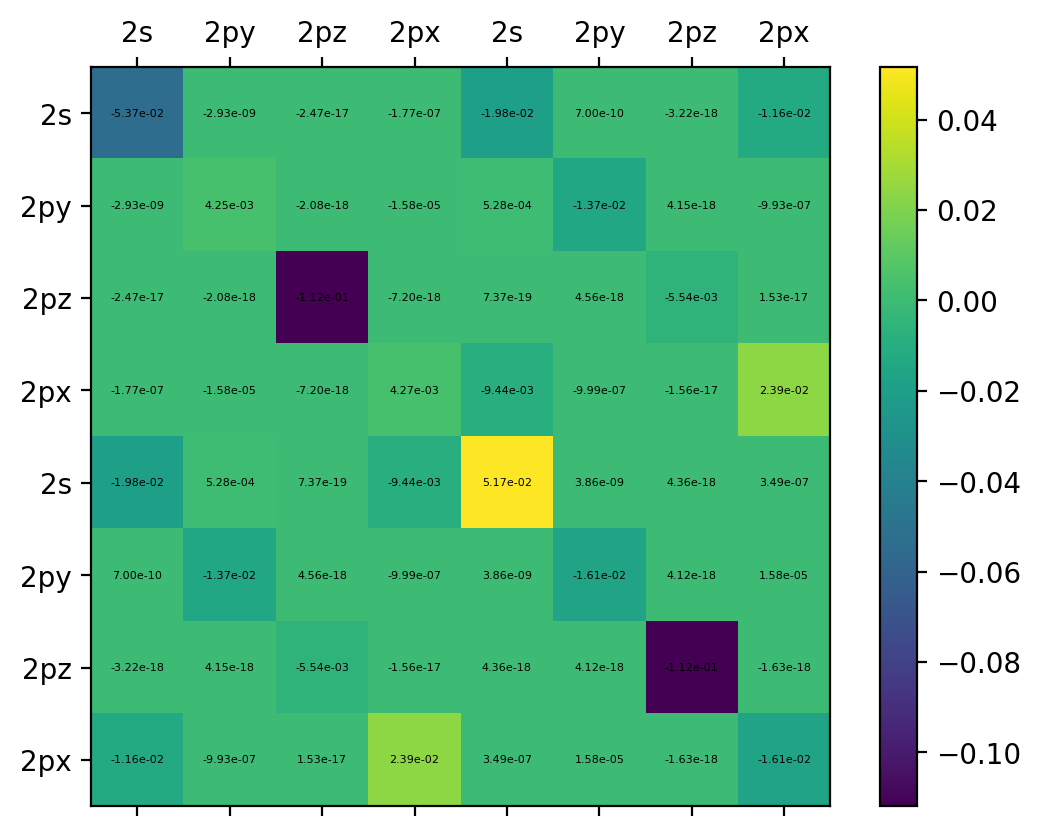

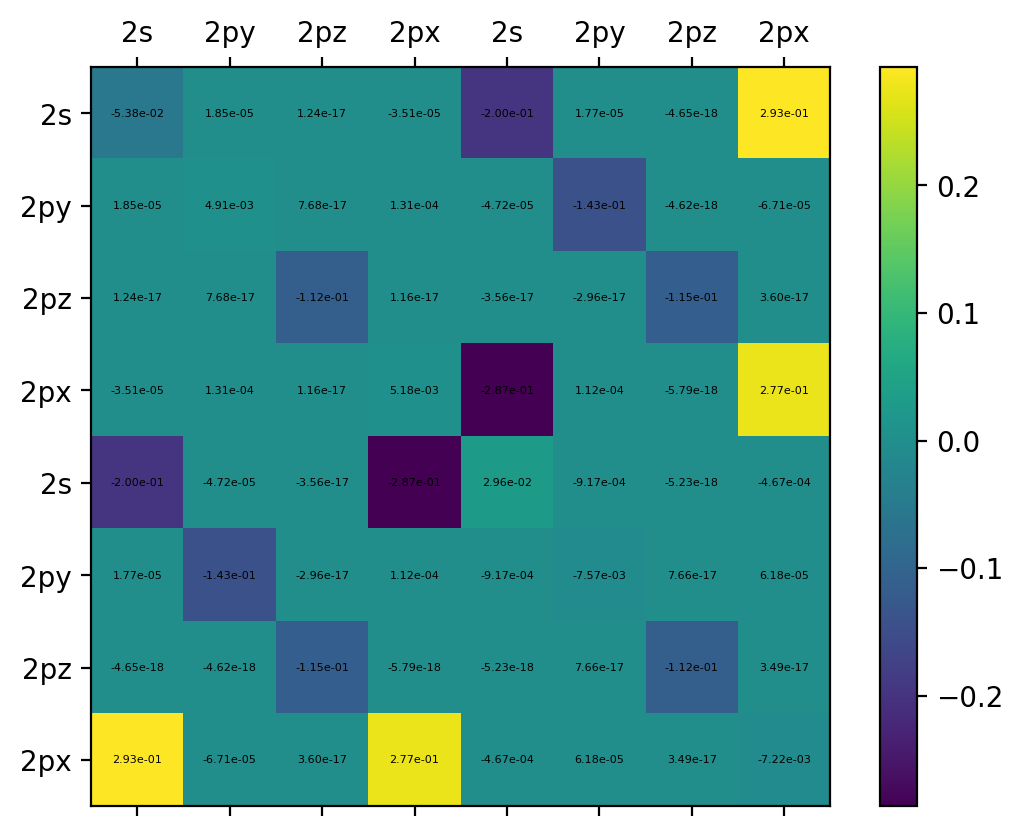

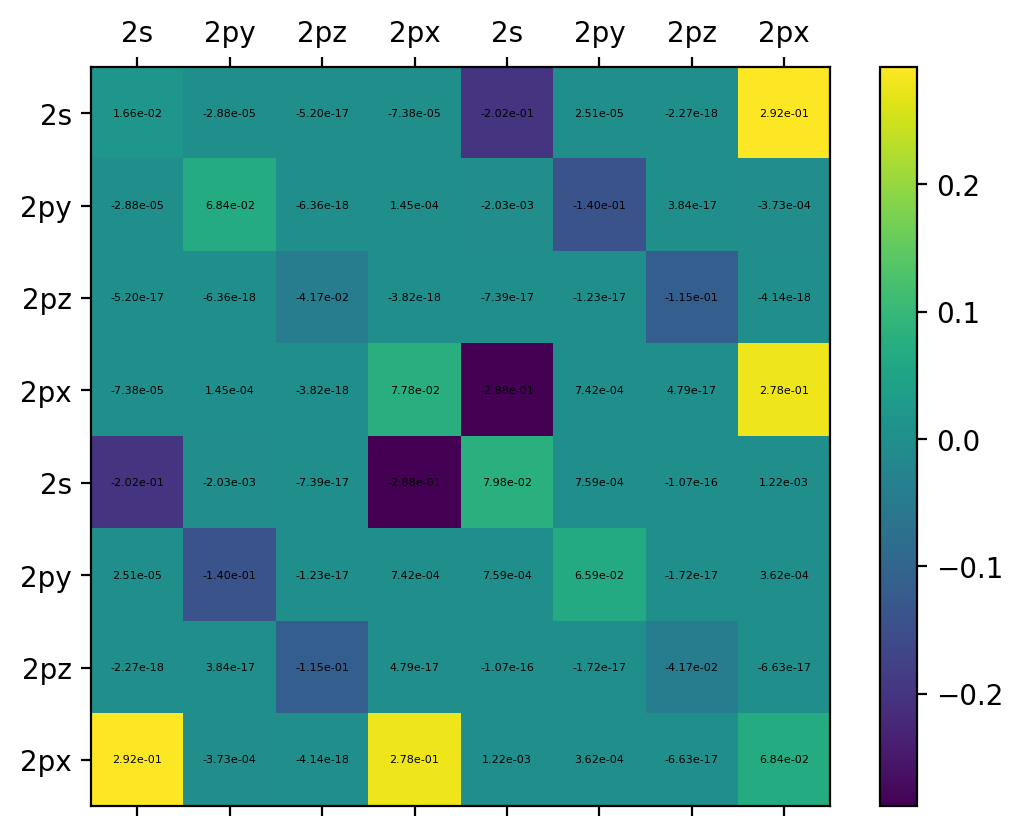

In [ ]:
f,a,m=plot_hamiltonian(HT[0][0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)
f,a,m=plot_hamiltonian(HT[1][0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)
f,a,m=plot_hamiltonian(HT[2][0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)

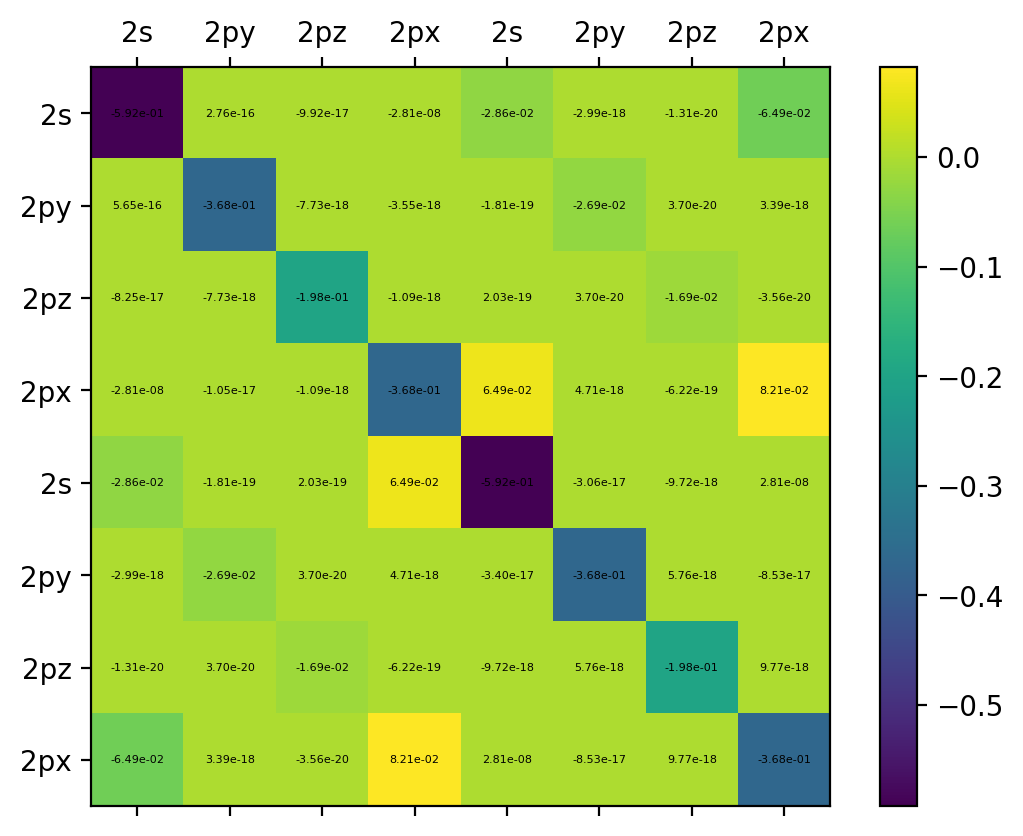

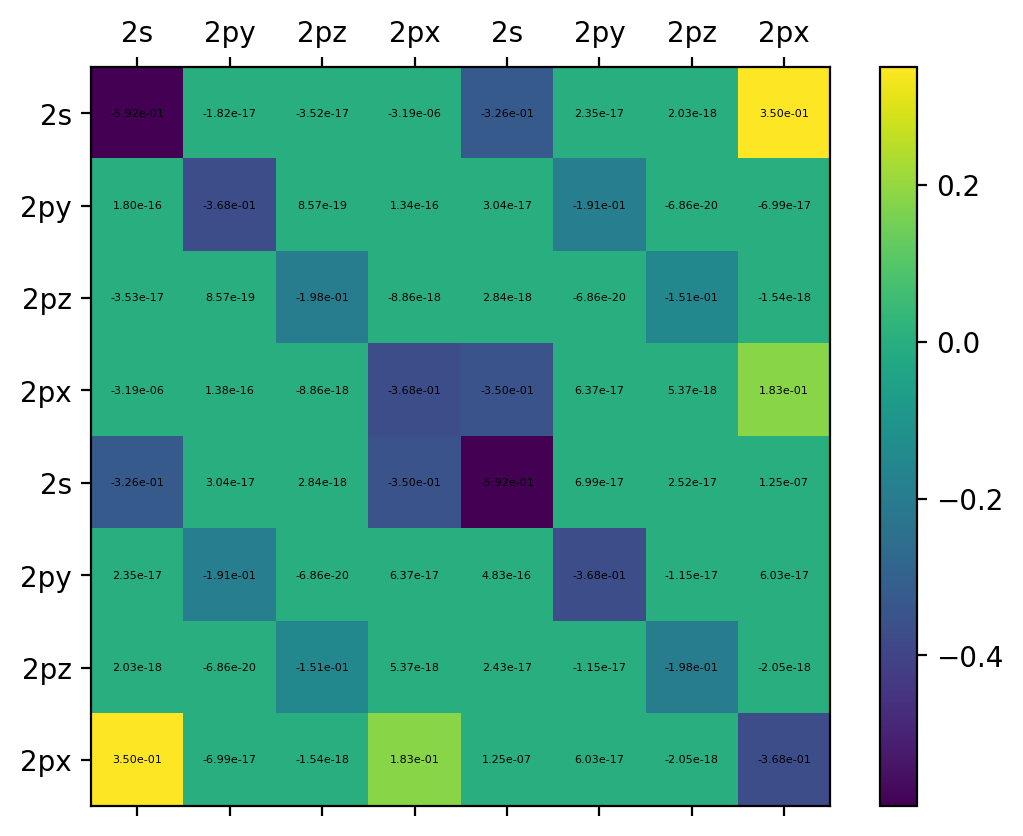

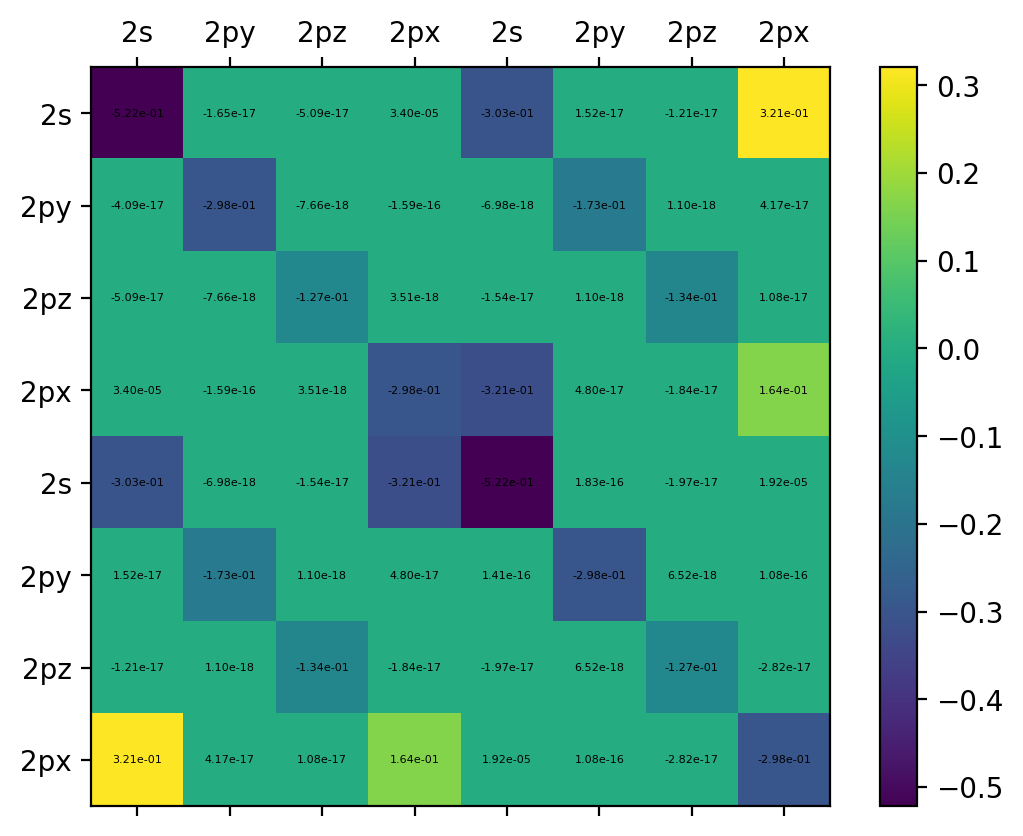

In [ ]:
plt.rcParams['figure.dpi']=200
f,a,m=plot_hamiltonian(f0[0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)
f,a,m=plot_hamiltonian(f1[0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)
f,a,m=plot_hamiltonian(f2[0,0,0][:8,:8], tick_labels=["2s", "2py", "2pz", "2px", "2s", "2py", "2pz", "2px"])
f.colorbar(ax=a,mappable=m)

In [ ]:
ok0_resh = ok0.reshape(12,12,1,8,8)
fk0_resh = fk0.reshape(12,12,1,8,8)

fk0_L_resh = fk0_L.reshape(12,12,1,8,8)

In [ ]:
np.linalg.norm(fk0_L_resh_new[2,1,0] - fk0_L_resh_new[-2,-1,0].conj())

0.0

In [ ]:
fk0_L_resh = fk0_L.reshape(12,12,1,8,8)
fk0_L_resh_new = torch.zeros_like(fk0_L_resh)

for x in range(12):
    for y in range(12):
        fk0_L_resh_new[x,y] = (fk0_L_resh[x,y] + fk0_L_resh[-x,-y].conj())/2
        print(torch.norm(fk0_L_resh[x,y]), torch.norm(fk0_L_resh[-x,-y].conj()), torch.norm(fk0_L_resh[x,y]-fk0_L_resh[-x,-y].conj()))
print()
for x in range(12):
    for y in range(12):
        print(torch.norm(fk0_L_resh_new[x,y]), torch.norm(fk0_L_resh_new[-x,-y].conj()), torch.norm(fk0_L_resh_new[x,y]-fk0_L_resh_new[-x,-y].conj()))

tensor(1.2326) tensor(1.2326) tensor(0.)
tensor(1.2455) tensor(1.2455) tensor(0.0006)
tensor(1.2829) tensor(1.2829) tensor(0.0019)
tensor(1.3414) tensor(1.3414) tensor(0.)
tensor(1.4105) tensor(1.4105) tensor(0.0005)
tensor(1.4691) tensor(1.4691) tensor(0.0003)
tensor(1.4926) tensor(1.4926) tensor(3.3923e-16)
tensor(1.4691) tensor(1.4691) tensor(0.0003)
tensor(1.4105) tensor(1.4105) tensor(0.0005)
tensor(1.3414) tensor(1.3414) tensor(0.)
tensor(1.2829) tensor(1.2829) tensor(0.0019)
tensor(1.2455) tensor(1.2455) tensor(0.0006)
tensor(1.2455) tensor(1.2455) tensor(0.0001)
tensor(1.2455) tensor(1.2455) tensor(0.0019)
tensor(1.2706) tensor(1.2706) tensor(8.4558e-09)
tensor(1.3188) tensor(1.3188) tensor(0.0001)
tensor(1.3837) tensor(1.3837) tensor(3.1522e-05)
tensor(1.4499) tensor(1.4499) tensor(0.0014)
tensor(1.4934) tensor(1.4934) tensor(0.0003)
tensor(1.4934) tensor(1.4934) tensor(0.0004)
tensor(1.4499) tensor(1.4499) tensor(0.0006)
tensor(1.3837) tensor(1.3837) tensor(0.0001)
tensor(1.3

In [ ]:
torch.norm(fk0_L_resh_new - fk0_L_resh)/np.prod(fk0_L_resh.shape)

tensor(9.8511e-07)

In [ ]:
print_matrix(fk0_L_resh_new[1,0,0].imag)

  -0.0000000000    0.0365259554    0.0000000000   -0.0210881509    0.2211859802    0.1536037894   -0.0000000000   -0.0886829024 
  -0.0365259554    0.0000000000    0.0000000000    0.0000009637   -0.1486309114   -0.0296264350   -0.0000000000   -0.0902229537 
  -0.0000000000   -0.0000000000   -0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.1174610709   -0.0000000000 
   0.0210881509   -0.0000009637   -0.0000000000   -0.0000000000    0.0858119831   -0.0902226621    0.0000000000   -0.1338061841 
  -0.2211859802    0.1486309114    0.0000000000   -0.0858119831   -0.0000000000    0.0525985619   -0.0000000000   -0.0303677391 
  -0.1536037894    0.0296264350   -0.0000000000    0.0902226621   -0.0525985619    0.0000000000    0.0000000000   -0.0000009475 
   0.0000000000    0.0000000000   -0.1174610709   -0.0000000000    0.0000000000   -0.0000000000   -0.0000000000    0.0000000000 
   0.0886829024    0.0902229537    0.0000000000    0.1338061841    0.0303677391    0.0000009475  

In [ ]:
for T in HT[0]:
    print(T, torch.norm(HT[0][T]))

(-3, 1, 0) tensor(3.7982e-17)
(-2, -1, 0) tensor(5.5009e-17)
(-2, 0, 0) tensor(2.0937e-16)
(-2, 1, 0) tensor(6.4624e-17)
(-2, 2, 0) tensor(3.0411e-17)
(-1, -2, 0) tensor(8.3823e-17)
(-1, -1, 0) tensor(3.8014e-17)
(-1, 0, 0) tensor(2.1288e-16)
(-1, 1, 0) tensor(3.4213e-17)
(-1, 2, 0) tensor(9.5036e-18)
(0, -2, 0) tensor(4.1323e-18)
(0, -1, 0) tensor(7.9830e-17)
(0, 0, 0) tensor(1.2326)
(0, 1, 0) tensor(7.9830e-17)
(0, 2, 0) tensor(4.1323e-18)
(1, -3, 0) tensor(1.4785e-18)
(1, -2, 0) tensor(9.5036e-18)
(1, -1, 0) tensor(3.4213e-17)
(1, 0, 0) tensor(2.1288e-16)
(1, 1, 0) tensor(3.8014e-17)
(2, -2, 0) tensor(3.0411e-17)
(2, -1, 0) tensor(6.4624e-17)
(2, 0, 0) tensor(2.0937e-16)
(3, -1, 0) tensor(3.7982e-17)
(2, 1, 0) tensor(5.5009e-17)
(1, 2, 0) tensor(8.3823e-17)
(-1, 3, 0) tensor(1.4785e-18)
